In [1]:
from __future__ import print_function, division
import os

from IPython import display
import sys
import importlib
import time
from tqdm import tqdm


import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math

import healpy as hp
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import Galactic

import matplotlib as mpl
from matplotlib import rcParams
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from matplotlib import ticker
from matplotlib import colors

rcParams.update({'figure.autolayout': True})
#plt.rc('font', family='serif')

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
mpl.rc('axes',edgecolor='k')
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'

plt.rcParams['text.usetex'] = True
#plt.rcParams['font.family'] = "serif"
#plt.rcParams['font.serif'] = "cm"
#plt.rcParams['text.latex.preamble'] = "\usepackage{subdepth}, \usepackage{type1cm}"

/het/p4/ramirez/envs/gcw2/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


In [2]:
E_min = 1e2 #min gamma-ray energy (MeV)
E_max = 1e9 #max gamma-ray energy (MeV)
E_factor = 1.77828 # gamma-ray energy factor


print('Energy, [MeV]')
E = E_min
Energy_list = []

while E <= E_max:
    Energy_list.append(E)
    E *= E_factor
Energy_list.append(E)
    
print(Energy_list)

Energy, [MeV]
[100.0, 177.828, 316.22797584, 562.3418848767552, 1000.0013270386363, 1778.2823598462662, 3162.2839548674183, 5623.426311261633, 10000.026540790337, 17782.84719695664, 31622.88151340406, 56234.33773765618, 100000.39811211923, 177828.7079548194, 316229.2347818963, 562344.1236279506, 1000005.3081651119, 1778289.4394038552, 3162296.544303088, 5623448.698803295, 10000066.352107925, 17782917.99262648, 31623007.40792782, 56234561.61336988, 100000796.2258234, 177829415.91245726, 316230493.7288045, 562346362.3880585, 1000009289.3074368]


In [3]:
# load local directory
username="ramirez"
local_dir = "/het/p4/"+username+"/gcewavelets/skysearch/"

for i in range(len(Energy_list)):
    map1 = hp.read_map(local_dir + 'data/GALPROP/SA0/ics_anisotropic_healpix_57_SA0_R12.fits', i) # Flux in [MeV^2 cm^−2 sr^−1 s^−1 MeV^−1]
    map2 = hp.read_map(local_dir + 'data/GALPROP/SA0/ics_isotropic_healpix_57_SA0_R12.fits', i)
    map3 = hp.read_map(local_dir + 'data/GALPROP/SA0/pi0_decay_healpix_57_SA0_R12.fits', i)
    map4 = hp.read_map(local_dir + 'data/GALPROP/SA0/synchrotron_healpix_57_SA0_R12.fits', i)
    map5 = hp.read_map(local_dir + 'data/GALPROP/SA0/bremss_healpix_57_SA0_R12.fits', i)
    result_map = map1 + map2 + map3 + map4 + map5
    if i==0:
        background_maps = np.zeros( (len(Energy_list), len(result_map)) )
    background_maps[i] = map1+map2+map3+map4+map5

/het/p4/ramirez/envs/gcw2/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/het/p4/ramirez/envs/gcw2/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 256
  warnings.warn("NSIDE = {0:d}".format(nside))
/het/p4/ramirez/envs/gcw2/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/het/p4/ramirez/envs/gcw2/lib/python3.7/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


In [4]:
energy_centers = np.concatenate([Energy_list,[Energy_list[-1]*1.7]])
energy_centers = 0.5*(energy_centers[0:-1]+energy_centers[1:])

In [5]:
#theta and phi locations of each cell
theta_list,phi_list = hp.pix2ang(256, range(hp.nside2npix(256)))

In [6]:
#NEED EXPOSURE MAP
#for example purposes, will use a simple overall scaling in order to create mock maps
#NEED TO RETURN TO THIS FOR ACTUAL ANALYSIS

exposure = 1e6

exposure_factor = np.sum(background_maps,axis=1)/np.sum(background_maps)

In [7]:
#approximate angular size of the healpix cells (radians)
res = np.sqrt(4*np.pi/12/256/256)
print(res)
print(hp.nside2resol(256))

0.003997369952915971
0.003997369952915971


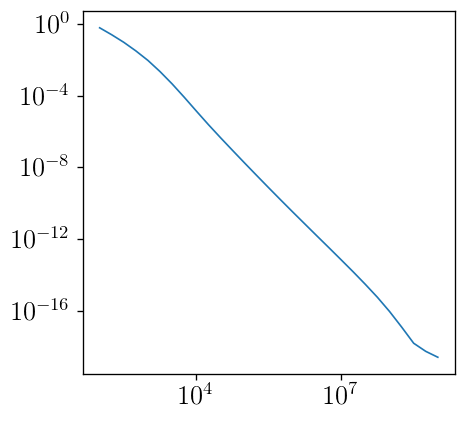

In [8]:
fig,ax = plt.subplots(1,1,figsize=(4,4), dpi= 120)
ax.plot(Energy_list,exposure_factor,lw=1)
ax.set_xscale('log')
ax.set_yscale('log')

In [9]:
random_map = np.einsum('ij,i->ij',background_maps,exposure_factor*exposure)

In [10]:
import astropy
from astropy import coordinates as coords
from astropy.coordinates import SkyCoord
from astropy.coordinates import Galactic
from astropy import units as u

In [11]:
#iterate through healpy cells, convert counts in healpy cells to individual events
res = np.sqrt(4*np.pi/12/512/512)
randomized_dict = {}

for ie in tqdm(range(len(Energy_list))):

    energy_dict = {}
    
    theta_events = np.array([])
    phi_events = np.array([])
    
    low = Energy_list[ie]
    if ie!= len(Energy_list)-1:
        high = Energy_list[ie+1]
    else:
        high = 1.8*Energy_list[-1]

    for i in range(len(random_map[ie])):
        counts = np.random.poisson(lam=random_map[ie,i])
        theta = theta_list[i]
        phi = phi_list[i]

        #generate 'counts' random numbers centered on theta,phi, smeared by a gaussian
        if counts==0:
            continue
        else:
            theta_events = np.concatenate([theta_events,theta+np.random.normal(size=int(counts),scale=res)])
            phi_events = np.concatenate([phi_events,phi+np.random.normal(size=int(counts),scale=res)])
            
#    phi_events[phi_events>np.pi] = phi_events[phi_events>np.pi]-2*np.pi
    #correctly orient in Galactic coords
    phi_events = -phi_events
    theta_events = theta_events-np.pi/2 
    theta_events = -theta_events 
    
    coordinates = SkyCoord(l=phi_events*u.rad,b=theta_events*u.rad,frame=Galactic)        
    energy_dict['coords'] = coordinates
    energy_events = np.random.uniform(size=len(coordinates),low=low,high=high)        
    energy_dict['energies'] = energy_events
    randomized_dict[ie] = energy_dict

100%|██████████| 29/29 [00:51<00:00,  1.78s/it]


In [12]:
phi_events

array([], dtype=float64)

0


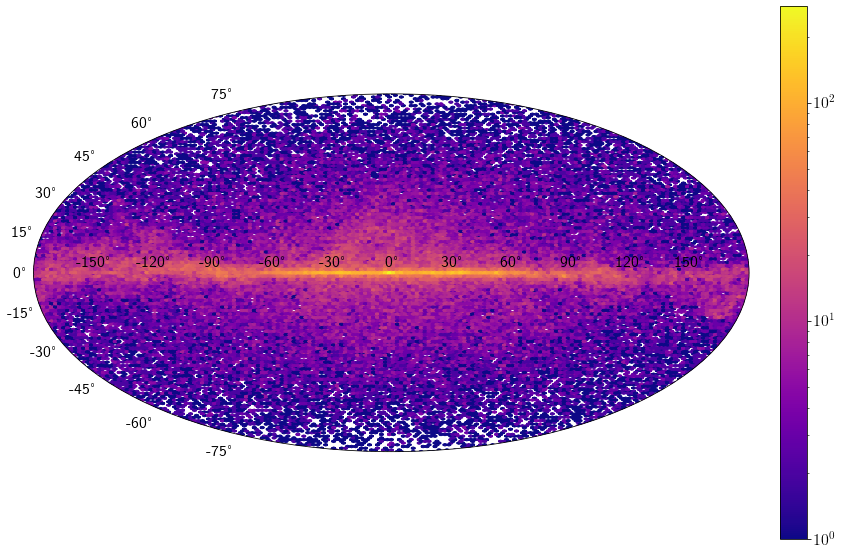

1


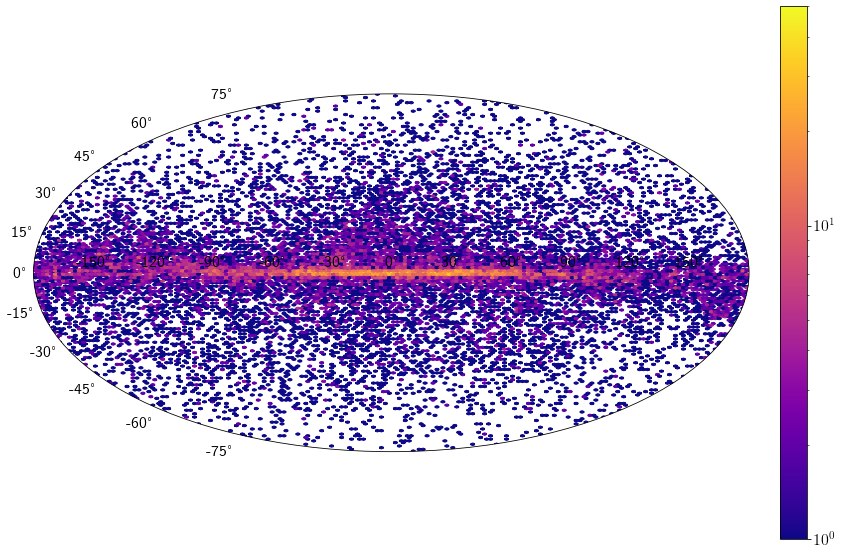

2


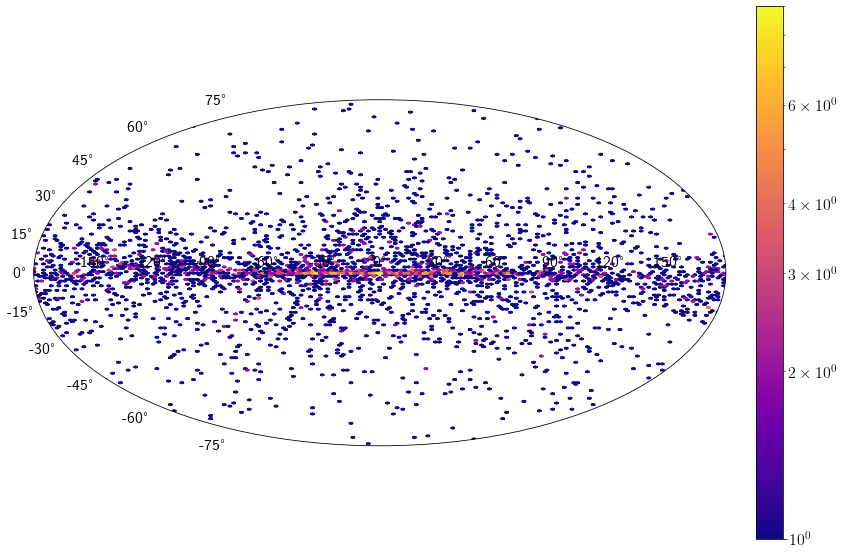

3


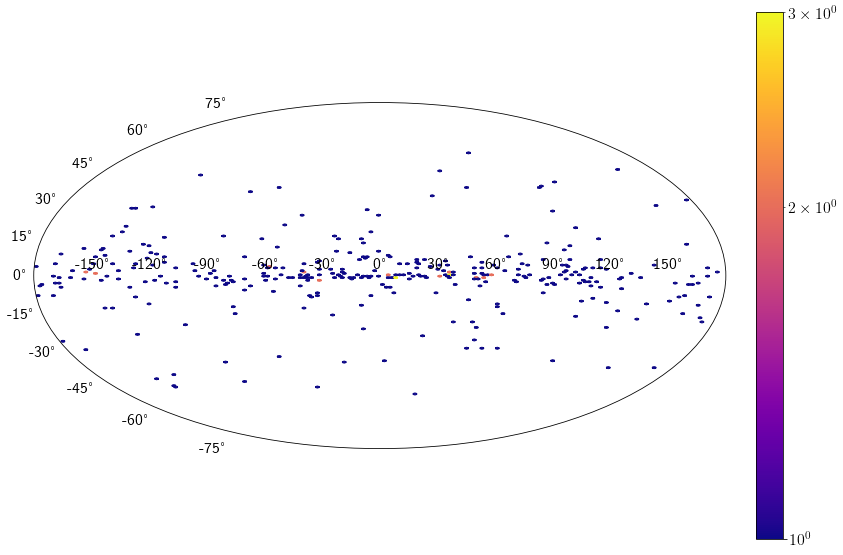

4


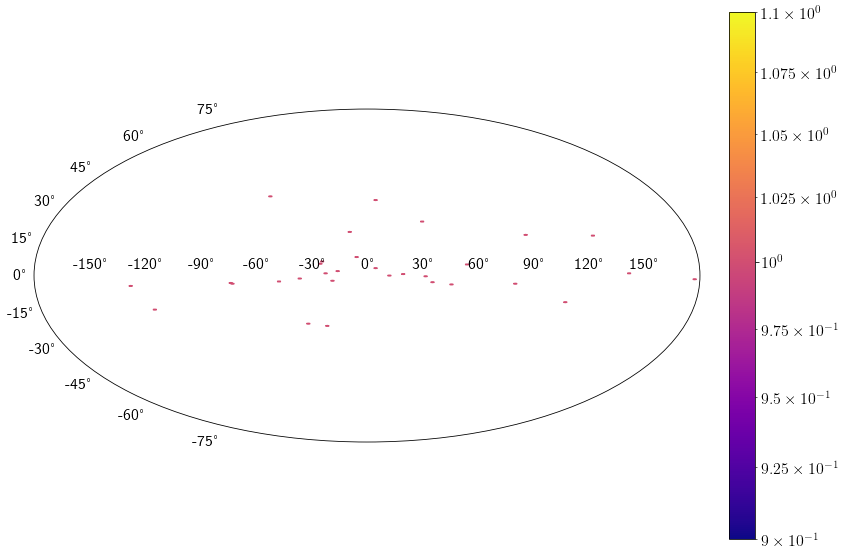

5


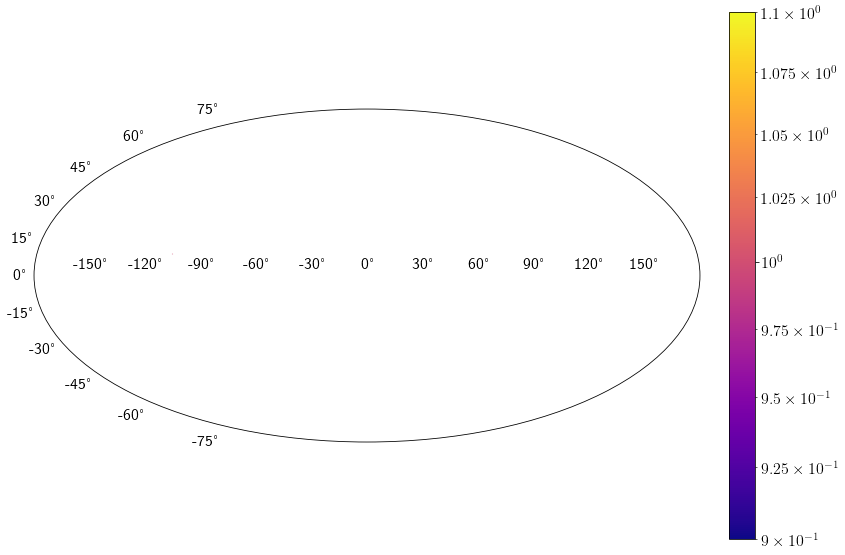

6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [13]:
for ie in range(len(Energy_list)):
    print(ie)

    phi_events = randomized_dict[ie]['coords'].l.rad

    phi_events[phi_events>np.pi] = phi_events[phi_events>np.pi]-2*np.pi

    if len(phi_events)>0:
        fig = plt.figure(1,figsize=(12,8))
        ax = fig.add_subplot(111, projection='mollweide')
        s = ax.hexbin(phi_events,
                      randomized_dict[ie]['coords'].b.rad,gridsize=200,cmap='plasma',mincnt=1,bins='log')

        plt.colorbar(s,fraction=0.046, pad=0.04)

        plt.tight_layout()
        plt.show()

In [14]:
#use PSF from psf_fitting notebook
popt = np.array([ 6.2652034 , -1.48602662,  0.05294771])

def line(x,a,b1,b2):
    return a+b1*x+b2*x**2

def psf(energy): #energy in MeV
    p = np.exp(line(np.log(energy),popt[0],popt[1],popt[2])) #degrees
    return p*np.pi/180 #radians

In [19]:
for ie in tqdm(range(len(Energy_list))):             
    coordinates = randomized_dict[ie]['coords'] 
    print(coordinates.shape)
    theta_events = coordinates.b.rad
    phi_events = coordinates.l.rad
    
    print(theta_events.shape)
    angular_offsets = np.random.normal(size=len(theta_events),scale=psf(randomized_dict[ie]['energies']))*u.rad
    azimuthal_offsets = np.random.uniform(size=len(theta_events),low=0,high=2*np.pi)*u.rad
    
    print(angular_offsets.shape)
    coordinates_new = coordinates.directional_offset_by(azimuthal_offsets, angular_offsets)
    
    print(coordinates_new.shape)
    
#    coordinates = SkyCoord(l=phi_events_new*u.rad,b=theta_events_new*u.rad,frame=Galactic) 
    randomized_dict[ie]['smeared_coords']  = coordinates_new

  3%|▎         | 1/29 [00:00<00:03,  8.84it/s]

(164520,)
(164520,)
(164520,)
(164520,)
(27502,)
(27502,)
(27502,)
(27502,)
(3995,)
(3995,)
(3995,)
(3995,)
(454,)
(454,)
(454,)
(454,)
(50,)
(50,)
(50,)
(50,)
(3,)
(3,)
(3,)
(3,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)

100%|██████████| 29/29 [00:00<00:00, 118.36it/s]


(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)


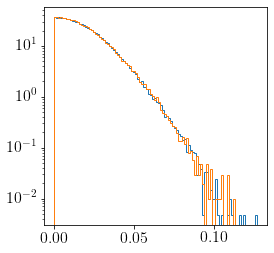

In [33]:
fig = plt.figure(1,figsize=(4,4))
ax = fig.add_subplot(111)

_,bins,_ = ax.hist(randomized_dict[0]['smeared_coords'].separation(randomized_dict[0]['coords']).rad,bins=100
               ,density=True,histtype='step')

ax.hist(np.random.normal(scale=psf(randomized_dict[0]['energies'])),bins=bins,
        density=True,histtype='step')

ax.set_yscale('log')

0


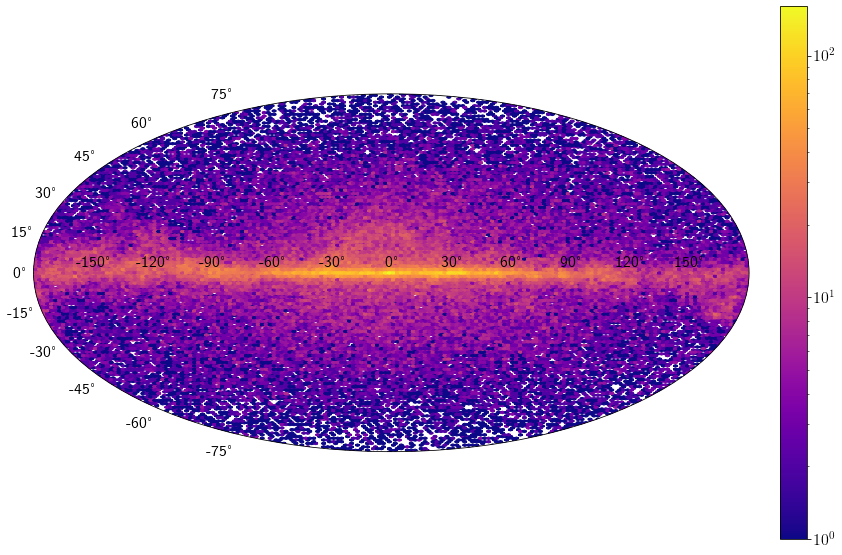

1


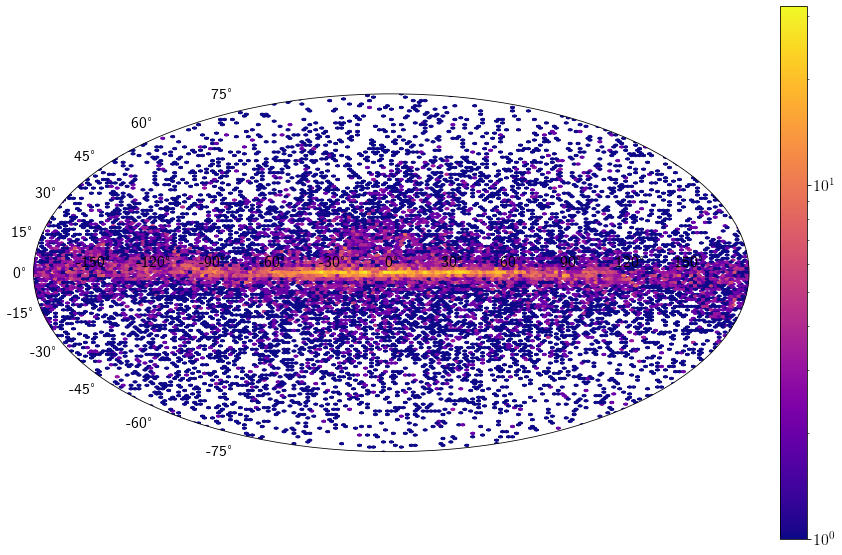

2


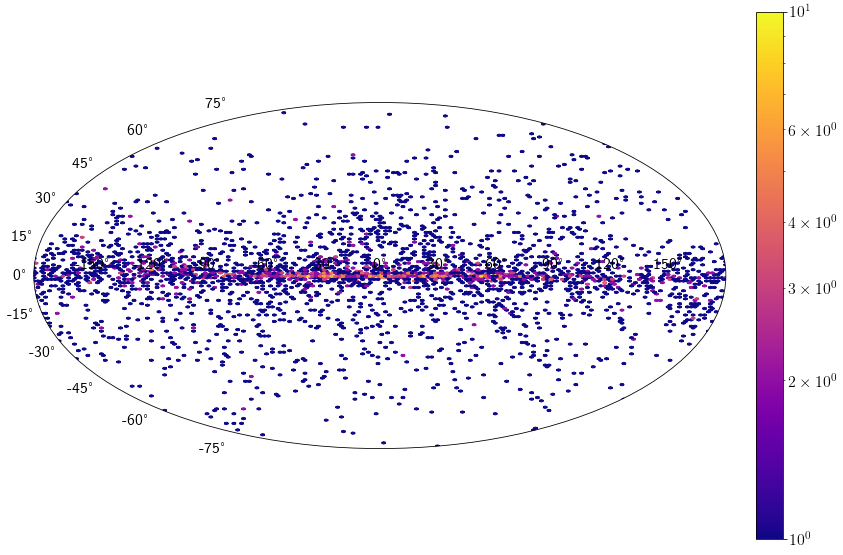

3


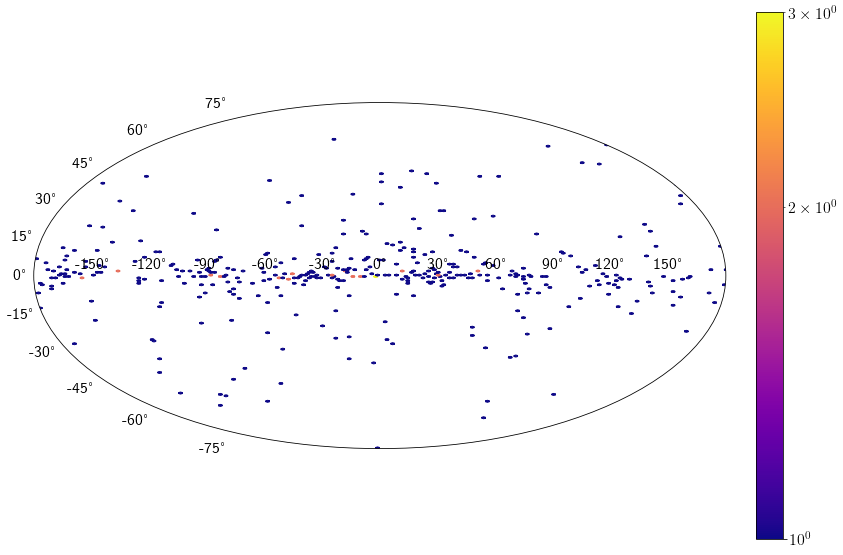

4


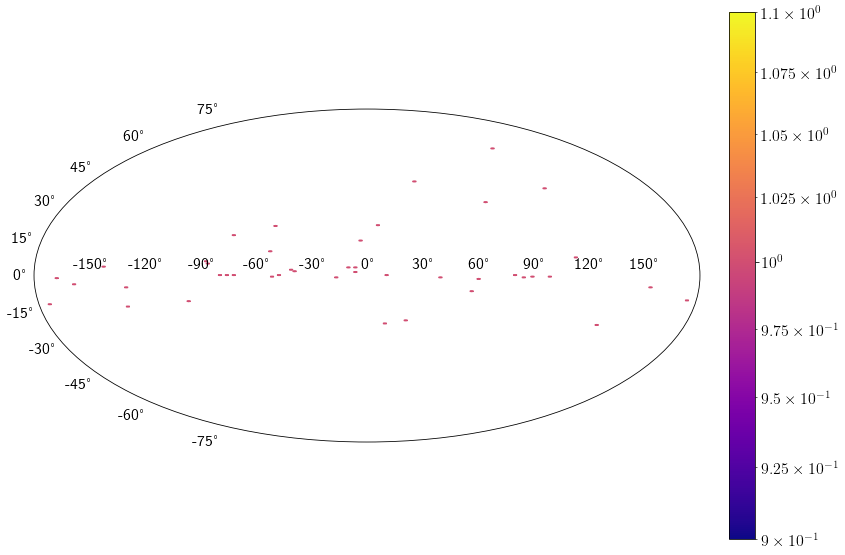

5


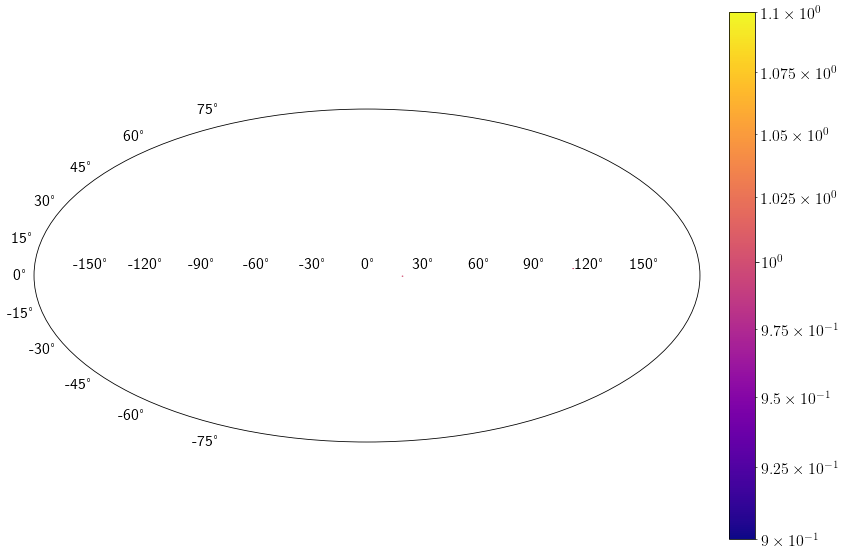

6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [34]:
for ie in range(len(Energy_list)):
    print(ie)

    phi_events = randomized_dict[ie]['smeared_coords'].l.rad

    phi_events[phi_events>np.pi] = phi_events[phi_events>np.pi]-2*np.pi

    if len(phi_events)>0:
        fig = plt.figure(1,figsize=(12,8))
        ax = fig.add_subplot(111, projection='mollweide')
        s = ax.hexbin(phi_events,
                      randomized_dict[ie]['smeared_coords'].b.rad,gridsize=200,cmap='plasma',mincnt=1,bins='log')

        plt.colorbar(s,fraction=0.046, pad=0.04)

        plt.tight_layout()
        plt.show()

In [15]:
#l, b in degrees
def generate_pointsource(l,b,photon_number,energy_bin=0,randomize_number=False):
    
    if randomize_number:
        counts = np.random.poisson(lam=photon_number)
    else:
        counts = photon_number
    
    #generate energies appropriate for the energy bin (uniform distribution for now)
    
    low = Energy_list[energy_bin]
    if energy_bin!= len(Energy_list)-1:
        high = Energy_list[energy_bin+1]
    else:
        high = 1.8*Energy_list[-1]

    energy_events = np.random.uniform(size=counts,low=low,high=high)    
    
    #create list of skycoords at the ps center
    
    l_list = l*np.ones(counts)
    b_list = b*np.ones(counts)
    
    coordinates = SkyCoord(l=l_list*u.rad,b=b_list*u.rad,frame=Galactic)
    
    #generate offsets from point source with gaussian with appropriate psf 
    angular_offsets = np.random.normal(size=counts,scale=psf(energy_events))*u.rad
    azimuthal_offsets = np.random.uniform(size=counts,low=0,high=2*np.pi)*u.rad
    
    
    coordinates_new = coordinates.directional_offset_by(azimuthal_offsets, angular_offsets)
    
    ps_dict = {}
    ps_dict['energies'] = energy_events
    ps_dict['coords'] = coordinates
    ps_dict['smeared_coords'] = coordinates_new
    
    return ps_dict

In [16]:
test_ps = generate_pointsource(10 * np.pi / 180,10 * np.pi / 180,1000,randomize_number=True)

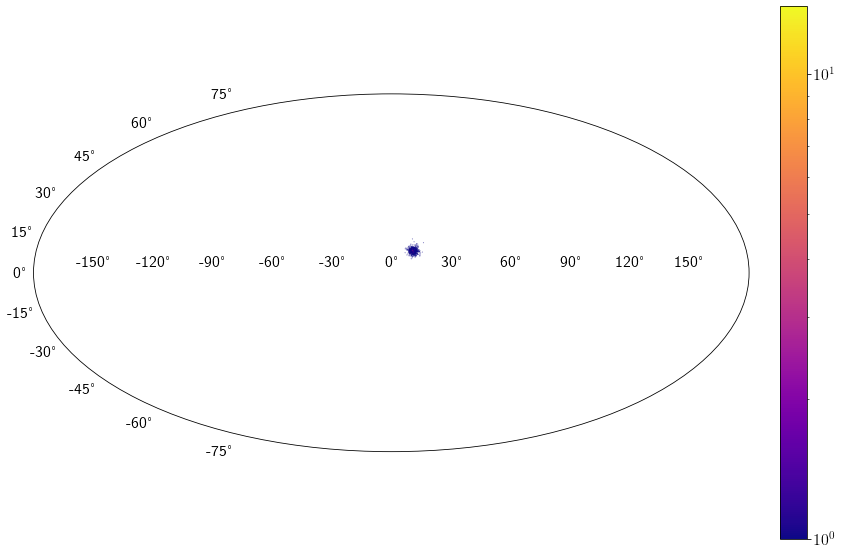

In [17]:
phi_events = test_ps['smeared_coords'].l.rad

phi_events[phi_events>np.pi] = phi_events[phi_events>np.pi]-2*np.pi

fig = plt.figure(1,figsize=(12,8))
ax = fig.add_subplot(111, projection='mollweide')
s = ax.hexbin(phi_events,
              test_ps['smeared_coords'].b.rad,gridsize=200,cmap='plasma',mincnt=1,bins='log')

plt.colorbar(s,fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [18]:
l_list = 2 * np.pi * np.random.random(1000)
b_list = ( -np.pi/2 + np.arccos( 2 * np.random.random(1000) - 1) ) 

In [ ]:
test_pss = [generate_pointsource(l_list[n], b_list[n], 1000, randomize_number = True) for n in range(1000)]

In [ ]:
fig = plt.figure(1,figsize=(12,8))
ax = fig.add_subplot(111, projection='mollweide')
for n in range(1000):
    phi_events = test_pss[n]['smeared_coords'].l.rad

    phi_events[phi_events>np.pi] = phi_events[phi_events>np.pi]-2*np.pi
    b_events = test_pss[n]['smeared_coords'].b.rad
    if n == 0:
        phi_events_tot = phi_events.copy()
        b_events_tot = b_events.copy()
    else:
        phi_events_tot = np.concatenate((phi_events_tot,phi_events))
        b_events_tot = np.concatenate((b_events_tot,b_events))
    
# s = ax.hexbin(phi_events_tot,
#               b_events_tot,gridsize=10000,cmap='plasma',mincnt=1,bins='log')

# plt.colorbar(s,fraction=0.046, pad=0.04)

# plt.tight_layout()

ax.scatter(phi_events_tot, b_events_tot, s = 0.1)

In [ ]:
import healpy as hp
import _maps as maps

NSIDE = 4
NPIX = hp.nside2npix(NSIDE)

# generate random points on plane around a pixel and see detect points inside it
# project boundaries into square region in plane tangent to center point

arr_edge_points = maps.healpix_edge_generator_(NSIDE = 4, step = 100)

In [ ]:
fig = plt.figure(1,figsize=(12,8))
ax = fig.add_subplot(111, projection='mollweide')
for n in range(1000):
    phi_events = test_pss[n]['smeared_coords'].l.rad

    phi_events[phi_events>np.pi] = phi_events[phi_events>np.pi]-2*np.pi
    b_events = test_pss[n]['smeared_coords'].b.rad
    if n == 0:
        phi_events_tot = phi_events.copy()
        b_events_tot = b_events.copy()
    else:
        phi_events_tot = np.concatenate((phi_events_tot,phi_events))
        b_events_tot = np.concatenate((b_events_tot,b_events))
    
# s = ax.hexbin(phi_events_tot,
#               b_events_tot,gridsize=10000,cmap='plasma',mincnt=1,bins='log')

# plt.colorbar(s,fraction=0.046, pad=0.04)

# plt.tight_layout()

ax.scatter(phi_events_tot, b_events_tot, s = 0.1)
for npix in range(NPIX):
    ax.plot(arr_edge_points[npix, :, 0] - np.pi, arr_edge_points[npix, :, 1], lw = 0.5)

In [ ]:
# produce array of datapoints 
## index 0: event number
## index 1: event properties
### 0: galactic longitude (rad)
### 1: galactic latitude (rad)
### 2: energy (MeV)
### 3: energy bin 
all_events = []
for ie in range(len(Energy_list)):
    coords = randomized_dict[ie]['smeared_coords']
    energies = randomized_dict[ie]['energies']
    
    l_events = coords.l.rad
    b_events = coords.b.rad
    e_events = energies
    e_bin_type = Energy_list[ie] * np.ones(len(l_events))

    if ie == 0:
        events = np.stack((l_events, b_events, e_events, e_bin_type), axis = -1)
    else:
        events_ie = np.stack((l_events, b_events, e_events, e_bin_type), axis = -1)
        events = np.concatenate((events, events_ie), axis = 0)
        
l_events_bkgd = events[:,0]
b_events_bkgd = events[:,1]

In [ ]:
fig = plt.figure(1,figsize=(12,8))
ax = fig.add_subplot(111, projection='mollweide')
for n in range(1000):
    phi_events = test_pss[n]['smeared_coords'].l.rad
    b_events = test_pss[n]['smeared_coords'].b.rad
    if n == 0:
        phi_events_tot = phi_events.copy()
        b_events_tot = b_events.copy()
    else:
        phi_events_tot = np.concatenate((phi_events_tot,phi_events))
        b_events_tot = np.concatenate((b_events_tot,b_events))

phi_events_tot = np.concatenate((phi_events_tot,l_events_bkgd))
b_events_tot = np.concatenate((b_events_tot,b_events_bkgd))

phi_events_tot[phi_events_tot>np.pi] = phi_events_tot[phi_events_tot>np.pi]-2*np.pi

s = ax.hexbin(phi_events_tot,
              b_events_tot,gridsize=200,cmap='plasma',mincnt=1,bins='log')

# plt.colorbar(s,fraction=0.046, pad=0.04)

# plt.tight_layout()

# ax.scatter(phi_events_tot, b_events_tot, s = 0.1)
for npix in range(NPIX):
    ax.plot(arr_edge_points[npix, :, 0] - np.pi, arr_edge_points[npix, :, 1], lw = 1, c = 'lightgreen')
    
plt.show()

In [ ]:
from astropy.coordinates import SkyOffsetFrame

In [ ]:
#recenter coordinates to a new coordinate system centered on a point
def recenter(coordinates,coordinate_center):
    coordinates_new = coordinates.transform_to(SkyOffsetFrame(origin=coordinate_center)) 
    return coordinates_new

In [ ]:
test_center = Galactic(b=10*u.deg,l=120*u.deg)

In [ ]:
recenter(test_ps['smeared_coords'],test_center)

In [ ]:
print(randomized_dict)

In [49]:
# produce array of datapoints 
## index 0: event number
## index 1: event properties
### 0: galactic longitude (rad)
### 1: galactic latitude (rad)
### 2: energy (MeV)
### 3: energy bin 
all_events = []
for ie in range(len(Energy_list)):
    coords = randomized_dict[ie]['smeared_coords']
    energies = randomized_dict[ie]['energies']
    
    l_events = coords.l.rad
    b_events = coords.b.rad
    e_events = energies
    e_bin_type = Energy_list[ie] * np.ones(len(l_events))
    if ie == 0:
        events = np.stack((l_events, b_events, e_events, e_bin_type), axis = -1)
    else:
        events_ie = np.stack((l_events, b_events, e_events, e_bin_type), axis = -1)
        events = np.concatenate((events, events_ie), axis = 0)

In [37]:
l_events_tot = events[:,0]
b_events_tot = events[:,1]

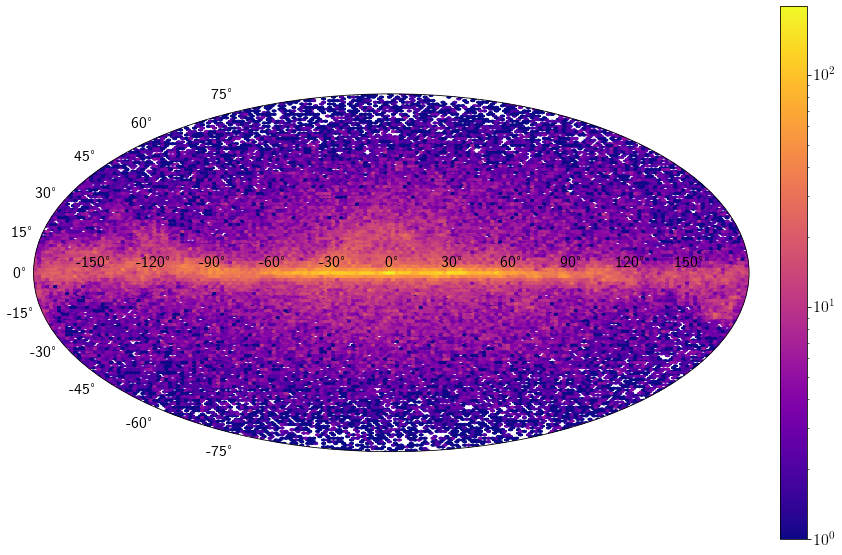

In [38]:
l_events_tot[l_events_tot>np.pi] = l_events_tot[l_events_tot>np.pi]-2*np.pi

fig = plt.figure(1,figsize=(12,8))
ax = fig.add_subplot(111, projection='mollweide')
s = ax.hexbin(l_events_tot,
              b_events_tot,gridsize=200,cmap='plasma',mincnt=1,bins='log')

plt.colorbar(s,fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [ ]:
np.save('sample_skymap_energy', events)

In [39]:
events.shape

(196231, 4)

In [51]:
is_in_bin = (events[:,-1] == Energy_list[0])
print(events[:,-1])
print(events[is_in_bin][:,-1])

[ 100.          100.          100.         ... 1000.00132704 1778.28235985
 1778.28235985]
[100. 100. 100. ... 100. 100. 100.]


In [48]:
Energy_list[ie]

1000009289.3074368